# PyBullet demo

This notebook demonstrates how to train a USA model on a PyBullet environment. The environment is taken from [here](https://github.com/adubredu/pybullet_kitchen).

To get started, first make sure to install some dependencies:

```bash
pip install pybullet scikit-learn scipy
```

In [1]:
import ml as ml_root
print(ml_root.__version__)

0.0.44


In [2]:
import os

# These environment variables control where training and eval logs are written.
# You can set these in your shell profile as well.
os.environ["RUN_DIR"] = "runs"
os.environ["EVAL_RUN_DIR"] = "eval_runs"
os.environ["MODEL_DIR"] = "models"
os.environ["DATA_DIR"] = "data"

# This is used to set a constant Tensorboard port.
os.environ["TENSORBOARD_PORT"] = str(8989)

# Useful for debugging.
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import ml.api as ml  # Source: https://github.com/codekansas/ml-starter

ml.configure_logging()

# Imports these files to add them to the model and task registry.
from usa.models.point2emb import Point2EmbModel, Point2EmbModelConfig
from usa.tasks.clip_sdf import ClipSdfTask

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import math
import pickle as pkl
import zipfile
from pathlib import Path
from typing import Iterator

import cv2
import imageio
import matplotlib.pyplot as plt
import ml.api as ml
import numpy as np
import pybullet as pb
import requests
import torch
from IPython.display import Image
from omegaconf import OmegaConf
from pyquaternion import Quaternion
from scipy.spatial.transform import Rotation
from torch import Tensor

pybullet build time: May  2 2023 06:00:32


In [4]:
pb.connect(pb.DIRECT)

0

The code below downloads the environment data and adds it to PyBullet.

In [5]:
data_root = Path("data")
data_root.mkdir(exist_ok=True)

# Downloads the dataset, if it is not already downloaded.
if not (data_root / "04_pybullet_data").exists():
    r = requests.get("https://github.com/codekansas/usa/releases/download/v0.0.2/04_pybullet_data.zip", allow_redirects=True)
    with open(data_root / "04_pybullet_data.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile(data_root / "04_pybullet_data.zip", "r") as zip_ref:
        zip_ref.extractall(data_root)

# Loads the URDFs into PyBullet.
pb.setAdditionalSearchPath(str(data_root / "04_pybullet_data"))
kitchen_path = "kitchen_part_right_gen_convex.urdf"
use_fixed_base = True
pb.setGravity(0, 0, -9.81)

def reset_simulation() -> None:
    pb.resetSimulation()
    pb.setGravity(0, 0, -9.81)
    pb.setPhysicsEngineParameter(enableConeFriction=0)
    
    floor = pb.loadURDF(
        "floor.urdf",
        useFixedBase=use_fixed_base,
    )

    kitchen = pb.loadURDF(
        "kitchen_part_right_gen_convex.urdf",
        (0.0, 0, 1.477),
        useFixedBase=use_fixed_base,
    )

    table = pb.loadURDF(
        "table.urdf",
        (2.5, 0, 0),
        pb.getQuaternionFromEuler((0, 0, 1.57)),
        useFixedBase=use_fixed_base,
    )

Next, let's collect some samples from the environment. The `PosedRGBDItem` used for training the model has the following description:

```python
class PosedRGBDItem(NamedTuple):
    image: Tensor       # RGB image, with shape (C, H, W)
    depth: Tensor       # Depth image, with shape (1, H, W)
    mask: Tensor        # Valid depth points, with shape (1, H, W), where True means valid
    intrinsics: Tensor  # Camera intrinsics matrix, with shape (3, 3)
    pose: Tensor        # Camera pose matrix, with shape (4, 4)

    def check(self) -> None:
        # Image should have shape (C, H, W)
        assert self.image.dim() == 3
        assert self.image.dtype == torch.float32
        # Depth should have shape (1, H, W)
        assert self.depth.dim() == 3
        assert self.depth.shape[0] == 1
        assert self.depth.dtype == torch.float32
        # Depth shape should match image shape.
        assert self.depth.shape[1:] == self.image.shape[1:]
        assert self.mask.shape[1:] == self.image.shape[1:]
        # Intrinsics should have shape (3, 3)
        assert self.intrinsics.shape == (3, 3)
        assert self.intrinsics.dtype == torch.float64
        # Pose should have shape (4, 4)
        assert self.pose.shape == (4, 4)
        assert self.pose.dtype == torch.float64
```

In the example below, we move the camera around the center point to collect a few frames.

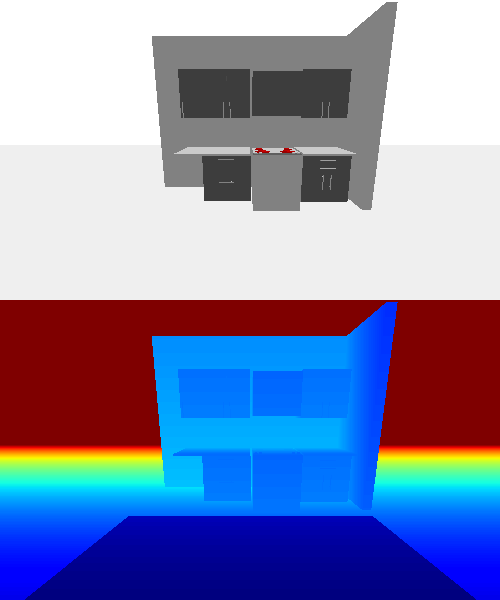

In [6]:
def capture_frame(
    camera_xyz: tuple[float, float, float] = (-5.0, 0.0, 1.477),
    camera_ypr: tuple[float, float, float] = (90.0, -10.0, 0.0),
    camera_planes: tuple[float, float] = (0.01, 10.0),
    pixel_dims: tuple[int, int] = (500, 300),
    camera_fov: float = 80.0,
) -> tuple[np.ndarray, ...]:
    """Captures a single frame, returning RGB and depth information.

    Args:
        camera_xyz: The XYZ coordinates of the camera
        camera_ypr: The yaw, pitch and roll of the camera
        camera_planes: The minimum and maximum rendering distances
        pixel_dims: The shape of the output image, as (W, H)
        camera_fov: The camera field of view
        
    Returns:
        The RGB image with shape (H, W, 3), the depth image with shape (H, W),
        the intrinsics matrix with shape (3, 3), and the pose matrix with
        shape (4, 4).
    """
    
    x, y, z = camera_xyz
    yaw, pitch, roll = camera_ypr
    near_plane, far_plane = camera_planes
    pixel_width, pixel_height = pixel_dims

    # Computes the view and projection matrices.
    view_mat = pb.computeViewMatrixFromYawPitchRoll(camera_xyz, near_plane, yaw, pitch, roll, 2)
    aspect = pixel_width / pixel_height
    proj_mat = pb.computeProjectionMatrixFOV(camera_fov, aspect, near_plane, far_plane)

    # Captures the camera image.
    img_arr = pb.getCameraImage(
        width=pixel_width,
        height=pixel_height,
        viewMatrix=view_mat,
        projectionMatrix=proj_mat,
    )
    img_width, img_height, rgb, depth, info = img_arr

    # Reshapes arrays to expected output shape.
    rgb_arr = np.reshape(rgb, (img_height, img_width, 4))[..., :3]
    depth_arr = np.reshape(depth, (img_height, img_width))
    
    # Converts depth to true depth.
    depth_arr = far_plane * near_plane / (far_plane - (far_plane - near_plane) * depth_arr)
    
    # Gets camera intrinsics matrix.
    cx = pixel_width / 2
    cy = pixel_height / 2
    fov_rad = np.deg2rad(camera_fov)
    fx = cx / np.tan(fov_rad / 2)
    fy = cy / np.tan(fov_rad / 2)
    
    """
    proj_mat_np = np.array(proj_mat, dtype=np.float64).reshape(4, 4, order="F")
    fx = proj_mat_np[0, 0]
    fy = proj_mat_np[1, 1]
    cx = proj_mat_np[0, 2]
    cy = proj_mat_np[1, 2]
    """
    
    intr = np.eye(3)
    intr[0, 0] = fx
    intr[1, 1] = fy
    intr[0, 2] = cx
    intr[1, 2] = cy
    
    # Gets poses from view matrix.
    pose = np.linalg.inv(np.array(view_mat, dtype=np.float64).reshape(4, 4, order="F"))
    affine_mat = np.array(
        [
            [1, 0, 0, 0],
            [0, -1, 0, 0],
            [0, 0, -1, 0],
            [0, 0, 0, 1],
        ]
    )
    pose = pose @ affine_mat
    
    return rgb_arr, depth_arr, intr, pose


def capture_sim(capture_every: int = 1) -> Iterator[tuple[np.ndarray, ...]]:
    # xyz, ypr = (-5.0, 0.0, 1.477), (90.0, -10.0, 0.0)
    for i in range(90):
        degs = i * 4
        rads = np.deg2rad(degs)
        dist = 3.0
        xyz = (dist * np.cos(rads), dist * np.sin(rads), 1.477)
        # xyz = (0.0, 0.0, 1.477 + np.sin(rads) * 0.5)
        # xyz = (0.0, 0.0, 1.477)
        # ypr = (degs, -10.0 + np.sin(rads) * 10.0, 0.0)
        ypr = (degs + 90.0, -10.0, 0.0)
        if i % capture_every == 0:
            yield capture_frame(xyz, ypr)


def write_gif(frames: Iterator[tuple[np.ndarray, ...]], out_file: str | Path, pkl_file: str | Path, *, fps: int = 30) -> None:
    rgb, depth, mask, poses, intrinsics = [], [], [], [], []

    #writer = imageio.get_writer(str(out_file), mode="I", fps=fps)
    writer = imageio.get_writer(str(out_file), mode="I", duration=1000/fps)
    for rgb_frame, depth_frame, intr, pose in frames:
        # Adds to the lists.
        rgb.append(rgb_frame)
        depth.append(depth_frame)
        mask.append(depth_frame > 7.0)
        # mask.append(np.zeros_like(depth_frame, dtype=np.bool_))
        poses.append(pose)
        intrinsics.append(intr)

        # Adds the image to the GIF.
        depth_normalized = (depth_frame - np.min(depth_frame)) / (np.max(depth_frame) - np.min(depth_frame) + 1e-3)
        depth_colorized = (plt.cm.jet(depth_normalized)[..., :3] * 255).astype(np.uint8)
        frame = np.concatenate([rgb_frame, depth_colorized], axis=0)
        writer.append_data(frame)

    # Saves the pickle file.
    data = {
        "rgb": np.stack(rgb),
        "depth": np.stack(depth),
        "mask": np.stack(mask),
        "poses": np.stack(poses),
        "intrinsics": np.stack(intrinsics),
    }
    with open(pkl_file, "wb") as f:
        pkl.dump(data, f)

    # Closes the writer.
    writer.close()


def iter_frames() -> Iterator[np.ndarray]:
    reset_simulation()
    yield from capture_sim()


pkl_path = data_root / "04_recorded_clip.pkl"
write_gif(iter_frames(), "video.gif", pkl_path)

Image("video.gif")

We can visualize the point cloud for the dataset using the snippet below. Note that this requires `pythreejs`, which can be installed using:

```bash
pip install pythreejs
```

Also, if using a normal Jupyter notebook, you will need to enable the extension using the code below (see the project page [here](https://github.com/jupyter-widgets/pythreejs)):

```bash
jupyter nbextension list
jupyter nbextension install --py --symlink --sys-prefix pythreejs
jupyter nbextension enable --py --sys-prefix pythreejs
jupyter nbextension list
```

In [7]:
from usa.tasks.datasets.utils import visualize_posed_rgbd_dataset
from usa.tasks.datasets.pybullet import PyBulletDataset

# Creates a new dataset from the recorded pickle file.
dataset = PyBulletDataset(path=pkl_path)

# Creates a point cloud of the dataset.
out_path = Path("out/point_cloud.ply")
visualize_posed_rgbd_dataset(
    dataset,
    make_video=False,
    make_point_cloud=True,
    max_point_cloud_samples=2,
    point_cloud_sample_stride=5,
    output_dir=out_path.parent,
)

if False:  # This is just for testing
    # Plots the point cloud using PyVista.
    import pyvista as pv
    pv.set_jupyter_backend("pythreejs")
    cloud = pv.read("out/point_cloud.ply")
    cloud.plot()

Processing point cloud:  39%|███▉      | 9/23 [00:10<00:15,  1.11s/it]

  INFO   2023-06-12 02:53:14 [usa.tasks.datasets.utils] Saved point cloud to /scratch/pl2285/robot/usa/notebooks/out/point_cloud.ply


Next, we train a model on the recorded clip.

In [8]:
# Using the default config, but overriding the dataset.
config = OmegaConf.load("config.yaml")
config.task.dataset = "pybullet"
config.task.dataset_path = str(pkl_path)

# We still need to explicitly set these variables.
config.trainer.exp_name = "4_256_no"
config.trainer.base_run_dir = "pybullet"
config.trainer.run_id = 3

# Only use stdout logger.
config.logger = [{"name": "stdout"}]
config.task.dataloader.train.batch_size = 8

# You can change this number to change the number of training steps.
config.task.finished.max_steps = 6000
#config.task.finished.max_epochs = 1000

# Loads the config objects.
objs = ml.instantiate_config(config)

# Unpacking the different components.
model = objs.model
#model_conf = Point2EmbModelConfig()
#model_conf.num_layers = 8
#model_conf.hidden_dims = 512 
#model_conf.norm = "layer"
#model_conf.num_pos_embs = 6 
#model_conf.output_dims = 513
#model = Point2EmbModel(model_conf)
task = objs.task
optimizer = objs.optimizer
lr_scheduler = objs.lr_scheduler
trainer = objs.trainer

# Runs the training loop.
trainer.train(model, task, optimizer, lr_scheduler)

  INFO   2023-06-12 02:53:17 [ml.trainers.base] Experiment directory: /scratch/pl2285/robot/usa/notebooks/pybullet/4_256_no/run_3
  INFO   2023-06-12 02:53:17 [ml.core.registry] Components:
 ↪ Model: usa.models.point2emb.Point2EmbModel (/ext3/miniconda3/lib/python3.10/site-packages/usa/models/point2emb.py)
 ↪ Task: usa.tasks.clip_sdf.ClipSdfTask (/ext3/miniconda3/lib/python3.10/site-packages/usa/tasks/clip_sdf.py)
 ↪ Trainer: ml.trainers.sl.SupervisedLearningTrainer (/ext3/miniconda3/lib/python3.10/site-packages/ml/trainers/sl.py)
 ↪ Optimizer: ml.optimizers.adam.AdamOptimizer (/ext3/miniconda3/lib/python3.10/site-packages/ml/optimizers/adam.py)
 ↪ LR Scheduler: ml.lr_schedulers.linear.LinearLRScheduler (/ext3/miniconda3/lib/python3.10/site-packages/ml/lr_schedulers/linear.py)
 ↪ Launcher: ml.launchers.slurm.SlurmLauncher (/ext3/miniconda3/lib/python3.10/site-packages/ml/launchers/slurm.py)
WARNING  2023-06-12 02:53:17 [ml.trainers.base] Overwriting config /scratch/pl2285/robot/usa/not

/ext3/miniconda3/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


WARNING  2023-06-12 02:53:17 [ml.utils.timer] Finished getting datasets in 0.316 seconds
  INFO   2023-06-12 02:53:22 [stdout] valid [5 seconds] {"loss": {"clip": 2.981, "sdf": 0.03555}, "task": {"pmax": 1.115, "pmin": -1.36}, "timers": {"epoch": 545, "dt": {"forward": 3.948, "get_single_loss": 0.000247, "iter": 7.7, "log_losses": 0.0004227}, "hours": {"epoch": -1.738e-11}, "samples": {"hour": 0, "second": 0, "total": 48000}, "steps": {"hour": 0, "second": 0, "total": 6000}}}
  INFO   2023-06-12 02:53:22 [ml.trainers.base] Saving checkpoint to /scratch/pl2285/robot/usa/notebooks/pybullet/4_256_no/run_3/checkpoints/ckpt.6000.pt
  INFO   2023-06-12 02:53:22 [ml.trainers.sl] Finished training after 545 epochs, 6000 steps, 48000 samples
  INFO   2023-06-12 02:53:22 [ml.trainers.base] Exiting training job for /scratch/pl2285/robot/usa/notebooks/pybullet/4_256_no/run_3/config.yaml


In [9]:
import sys
sys.path.append('../usa')
from planners.clip_sdf import AStarPlanner, GradientPlanner

dataset = task._dataset()
grid_planner = AStarPlanner(
    dataset=dataset,
    model=model.double(),
    task=task.double(),
    device=task._device,
    # The heuristic to use for AStar
    heuristic="euclidean",
    # The grid resolution
    resolution=0.1,
    # Where to store cache artifacts
    cache_dir=None,
    occ_avoid_radius = 0.15
).double()

# Builds the planner from the model and task.
gradient_planner = GradientPlanner(
    dataset=dataset,
    model=model.double(),
    task=task.double(),
    device=task._device,

    # The learning rate for the optimizer for the waypoints
    lr=1e-3,
    # The weight for the total path distance loss term
    dist_loss_weight=1.0,
    # The weight for the inter-point distance loss term
    spacing_loss_weight=1.0,
    # The weight for the "no-crashing-into-a-wall" loss term
    occ_loss_weight=25.0,
    # The weight for the loss term of the final semantic location
    sim_loss_weight=15.0,
    # Maximum number of optimization steps
    num_optimization_steps=2,
    # If points move less than this distance, stop optimizing
    min_distance=1e-5,
    # Where to store cache artifacts
    # cache_dir=Path("cache"),
    cache_dir=None,
    # Height of the floor
    floor_height=0.1,
    # Height of the ceiling
    ceil_height=2.5,
    occ_avoid_radius = 0.15
).double()

100%|██████████| 919/919 [00:02<00:00, 310.71it/s]


In [10]:
tokens = task.clip.tokenizer.tokenize("oven").cuda()
embs = task.clip.linguistic(tokens)
#grid_planner.occ_map

In [11]:
y_pixels, x_pixels = gradient_planner.occ_map.grid.shape
def occ_map_pt_to_xy(pt: tuple[int, int]) -> tuple[float, float]:
    return (
        pt[0] * gradient_planner.occ_map.resolution + gradient_planner.occ_map.origin[0],
        pt[1] * gradient_planner.occ_map.resolution + gradient_planner.occ_map.origin[1],
    )

x_min, y_min = occ_map_pt_to_xy((0, 0))
x_max, y_max = occ_map_pt_to_xy((x_pixels, y_pixels))

xs, ys, zs = torch.meshgrid(
    torch.arange(x_min, x_max, gradient_planner.occ_map.resolution * 3),
    torch.arange(y_min, y_max, gradient_planner.occ_map.resolution * 3),
    #torch.arange(gradient_planner.min_z, gradient_planner.max_z, 0.2),
    torch.tensor([gradient_planner.min_z, gradient_planner.max_z]),
    indexing="xy",
)
xs.shape, ys.shape, zs.shape

(torch.Size([187, 187, 2]),
 torch.Size([187, 187, 2]),
 torch.Size([187, 187, 2]))

torch.Size([187, 187])


<Axes: >

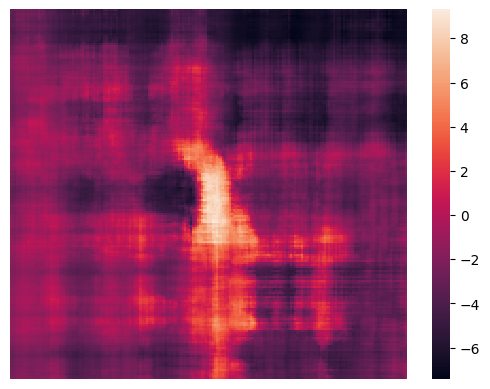

In [20]:
import seaborn
maps = model(torch.stack([xs, ys, zs], dim = -1).cuda())[:,:,:,:-1].detach()
sim = torch.cosine_similarity(maps, embs, dim = -1)
#sim = maps @ embs.T
#sim = sim[:, :, :, 0]
sim = torch.max(sim, dim = -1).values
print(sim.shape)
seaborn.heatmap(sim.cpu() * 100, yticklabels=False, xticklabels=False)

In [13]:
sim.max()

tensor(0.0931, device='cuda:0', dtype=torch.float64)

In [14]:
torch.arange(x_min, x_max, gradient_planner.occ_map.resolution * 3)[torch.where(sim == sim.max())[0].cpu()], torch.arange(y_min, y_max, gradient_planner.occ_map.resolution * 3)[torch.where(sim == sim.max())[1].cpu()]

(tensor([1.0445]), tensor([0.1406]))

<Axes: >

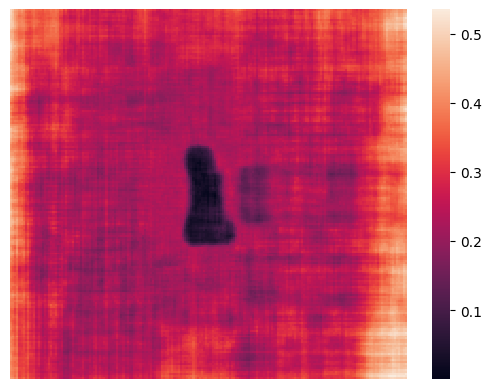

In [17]:
maps = model(torch.stack([xs, ys, zs], dim = -1).cuda())[:,:,:,-1].detach()
#sim = torch.cosine_similarity(maps, embs, dim = -1)
afford = torch.min(maps, dim = -1).values
seaborn.heatmap(afford.cpu().numpy(), yticklabels=False, xticklabels=False)

In [16]:
# If a model has already been trained, you can load trained model and task
# using this line:
# model, task = ml.load_model_and_task("runs/jupyter/run_0/config.yaml")

After the model has been trained, we can load it and visualize some of the planned trajectories.

100%|██████████| 9766/9766 [00:40<00:00, 243.74it/s]


<Axes: >

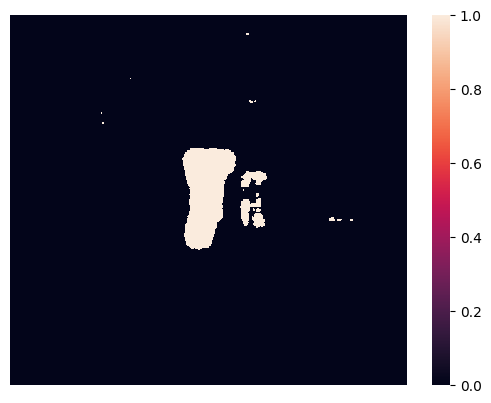

In [17]:
import seaborn
#seaborn.heatmap(gradient_planner.get_map().grid.max(axis = -1)[::-1], yticklabels=False, xticklabels=False)
seaborn.heatmap(gradient_planner.get_map().grid.max(axis = -1)[::-1], yticklabels=False, xticklabels=False)

We plot the occupancy grid with the camera trajectories below.

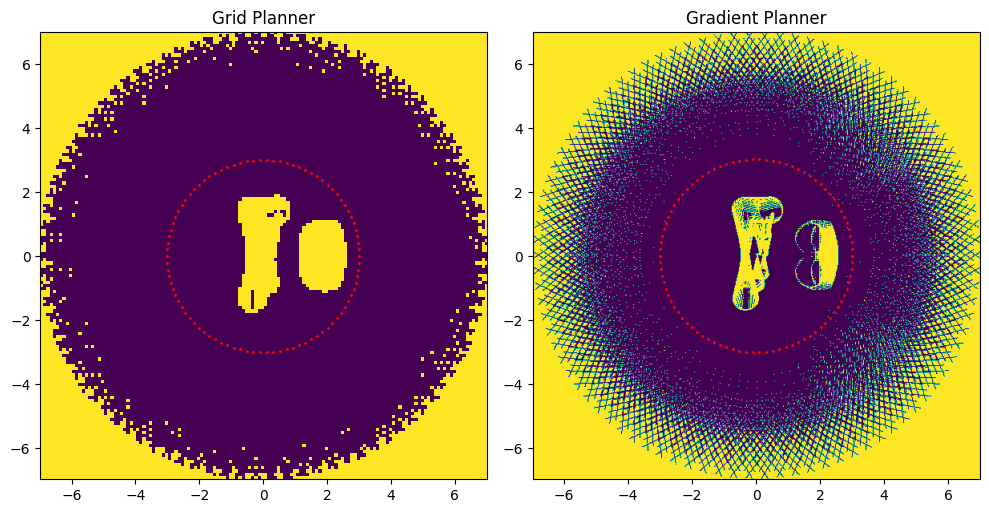

In [26]:
dataset = task._dataset()
poses = torch.stack([dataset[i].pose for i in range(len(dataset))])
xs, ys = poses[..., 0, 3].numpy(), poses[..., 1, 3].numpy()

plt.figure(figsize=(10, 20))

plt.subplot(1, 2, 1)
minx, miny = grid_planner.occ_map.origin
(ycells, xcells), resolution = grid_planner.occ_map.grid.shape, grid_planner.occ_map.resolution
maxx, maxy = minx + xcells * resolution, miny + ycells * resolution
plt.imshow(grid_planner.occ_map.grid[::-1], extent=(minx, maxx, miny, maxy))
plt.scatter(x=xs, y=ys, c='r', s=1.0)
plt.title("Grid Planner")

plt.subplot(1, 2, 2)
minx, miny = gradient_planner.occ_map.origin
(ycells, xcells), resolution = gradient_planner.occ_map.grid.shape, gradient_planner.occ_map.resolution
maxx, maxy = minx + xcells * resolution, miny + ycells * resolution
plt.imshow(gradient_planner.occ_map.grid[::-1], extent=(minx, maxx, miny, maxy))
plt.scatter(x=xs, y=ys, c='r', s=1.0)
plt.title("Gradient Planner")

plt.tight_layout()
plt.show();

In [27]:
# waypoints = [(-5.0 + i * 0.1, 0.0) for i in range(20)]
#waypoints = planner.plan(start_xy=(-0.0, -3.0), end_xy=(3.0, -1.0))
gradient_waypoints = gradient_planner.plan(start_xy=(-3.0, -3.0), end_goal="oven")
grid_waypoints = grid_planner.plan(start_xy=(-3.0, -3.0), end_goal="oven")
#waypoints = planner.plan(start_xy=(0.0, -3.0), end_xy=(1.0, -3.0))
grid_waypoints

100%|██████████| 2/2 [00:00<00:00, 167.50it/s]


[(-3.0, -3.0),
 (-0.08046874999999964, -1.8843749999999995),
 (0.11953125000000053, -1.7843749999999998),
 (0.21953125000000018, -1.6843749999999993),
 (0.6195312500000005, -0.6843749999999993),
 (1.1195312499999996, 1.015625),
 (1.51953125, 1.8156250000000007)]

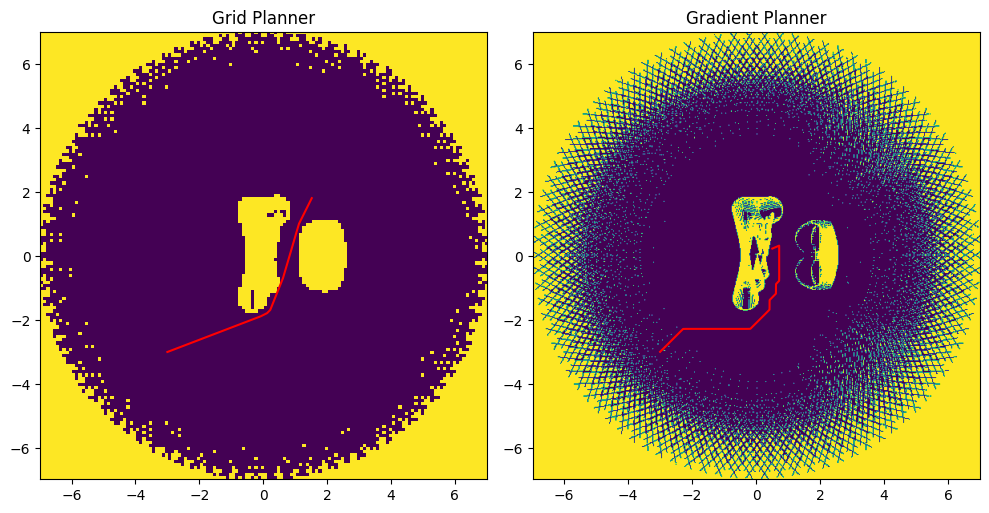

In [28]:
xs, ys = zip(*grid_waypoints)

plt.figure(figsize=(10, 20))

plt.subplot(1, 2, 1)
minx, miny = grid_planner.occ_map.origin
(ycells, xcells), resolution = grid_planner.occ_map.grid.shape, grid_planner.occ_map.resolution
maxx, maxy = minx + xcells * resolution, miny + ycells * resolution
plt.imshow(grid_planner.occ_map.grid[::-1], extent=(minx, maxx, miny, maxy))
#plt.imshow(sim.detach().cpu(), extent=(minx, maxx, miny, maxy))
plt.plot(xs, ys, c='r')
plt.title("Grid Planner")

xs, ys = zip(*gradient_waypoints)
plt.subplot(1, 2, 2)
minx, miny = gradient_planner.occ_map.origin
(ycells, xcells), resolution = gradient_planner.occ_map.grid.shape, gradient_planner.occ_map.resolution
maxx, maxy = minx + xcells * resolution, miny + ycells * resolution
plt.imshow(gradient_planner.occ_map.grid[::-1], extent=(minx, maxx, miny, maxy))
plt.plot(xs, ys, c='r')
plt.title("Gradient Planner")

plt.tight_layout()
plt.show();

Now that we've got our trajectory, we can run it in simulation.

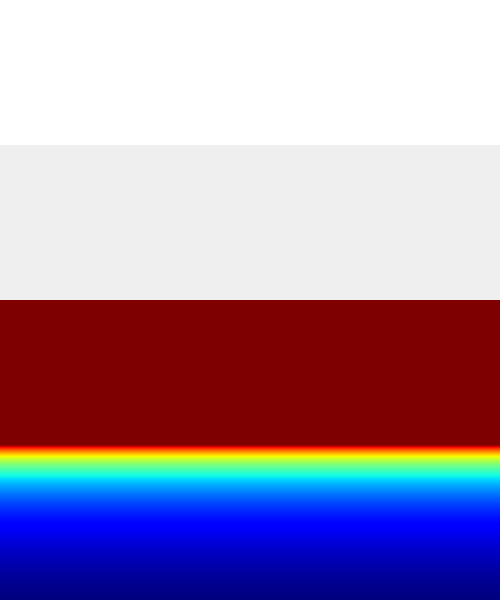

In [58]:
def iter_frames_for_waypoints(waypoints: list[tuple[float, float]], *, camera_z: float = 1.477, camera_pr: tuple[float, float, float] = (-10.0, 0.0)) -> Iterator[np.ndarray]:
    for i in range(len(waypoints) - 1):
        x, y = waypoints[i]
        xn, yn = waypoints[i + 1]
        dx, dy = xn - x, yn - y
        # yaw = np.rad2deg(math.atan2(dy, dx))
        yaw = np.rad2deg(math.atan2(y, x))  # Look towards origin
        dist = math.sqrt(dx ** 2 + dy ** 2)
        for j in np.arange(0, dist, 0.1):
            yield capture_frame((x + dx * j, y + dy * j, camera_z), (yaw, *camera_pr))


pkl_path = data_root / "04_recorded_clip_waypoints.pkl"
write_gif(iter_frames_for_waypoints(grid_waypoints), "grid_waypoints_video.gif", pkl_path)
Image("grid_waypoints_video.gif")

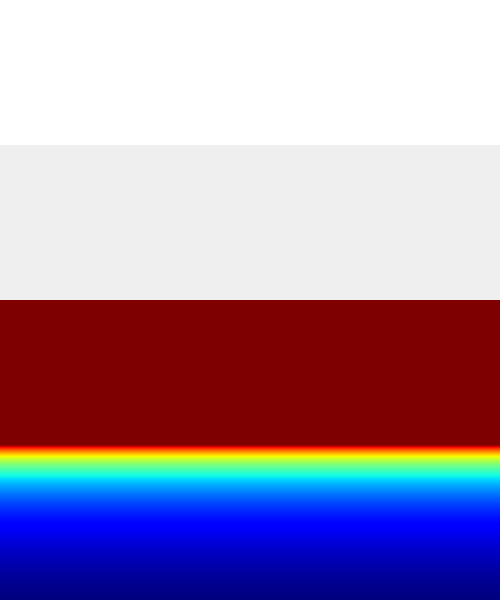

In [80]:
pkl_path = data_root / "04_recorded_clip_waypoints.pkl"
write_gif(iter_frames_for_waypoints(gradient_waypoints), "gradient_waypoints_video.gif", pkl_path)
Image("gradient_waypoints_video.gif")

(<Figure size 5000x3500 with 45 Axes>, <Figure size 5000x3500 with 45 Axes>)

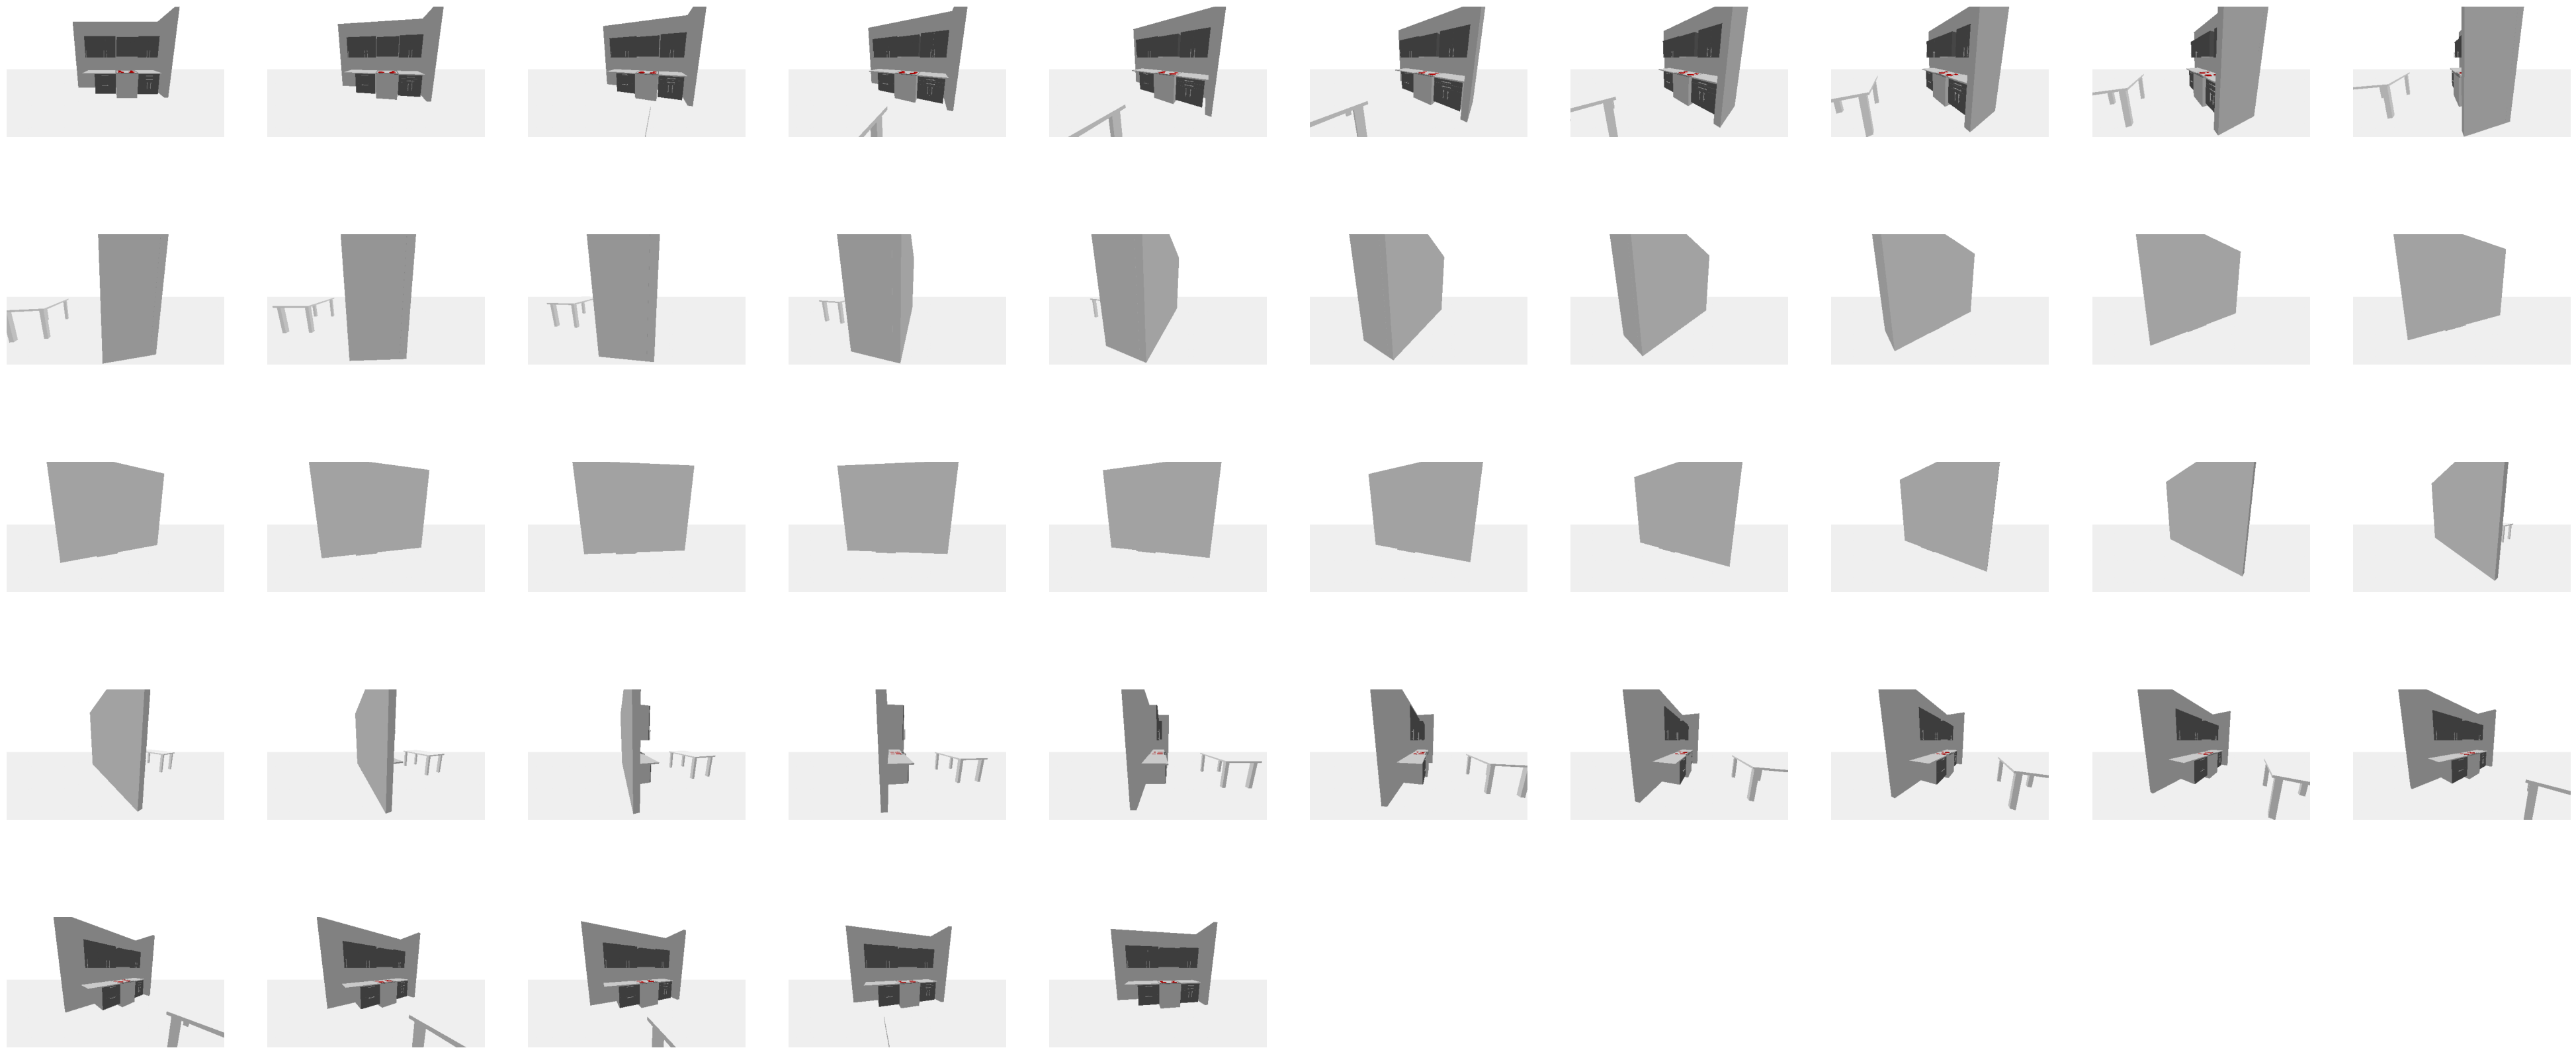

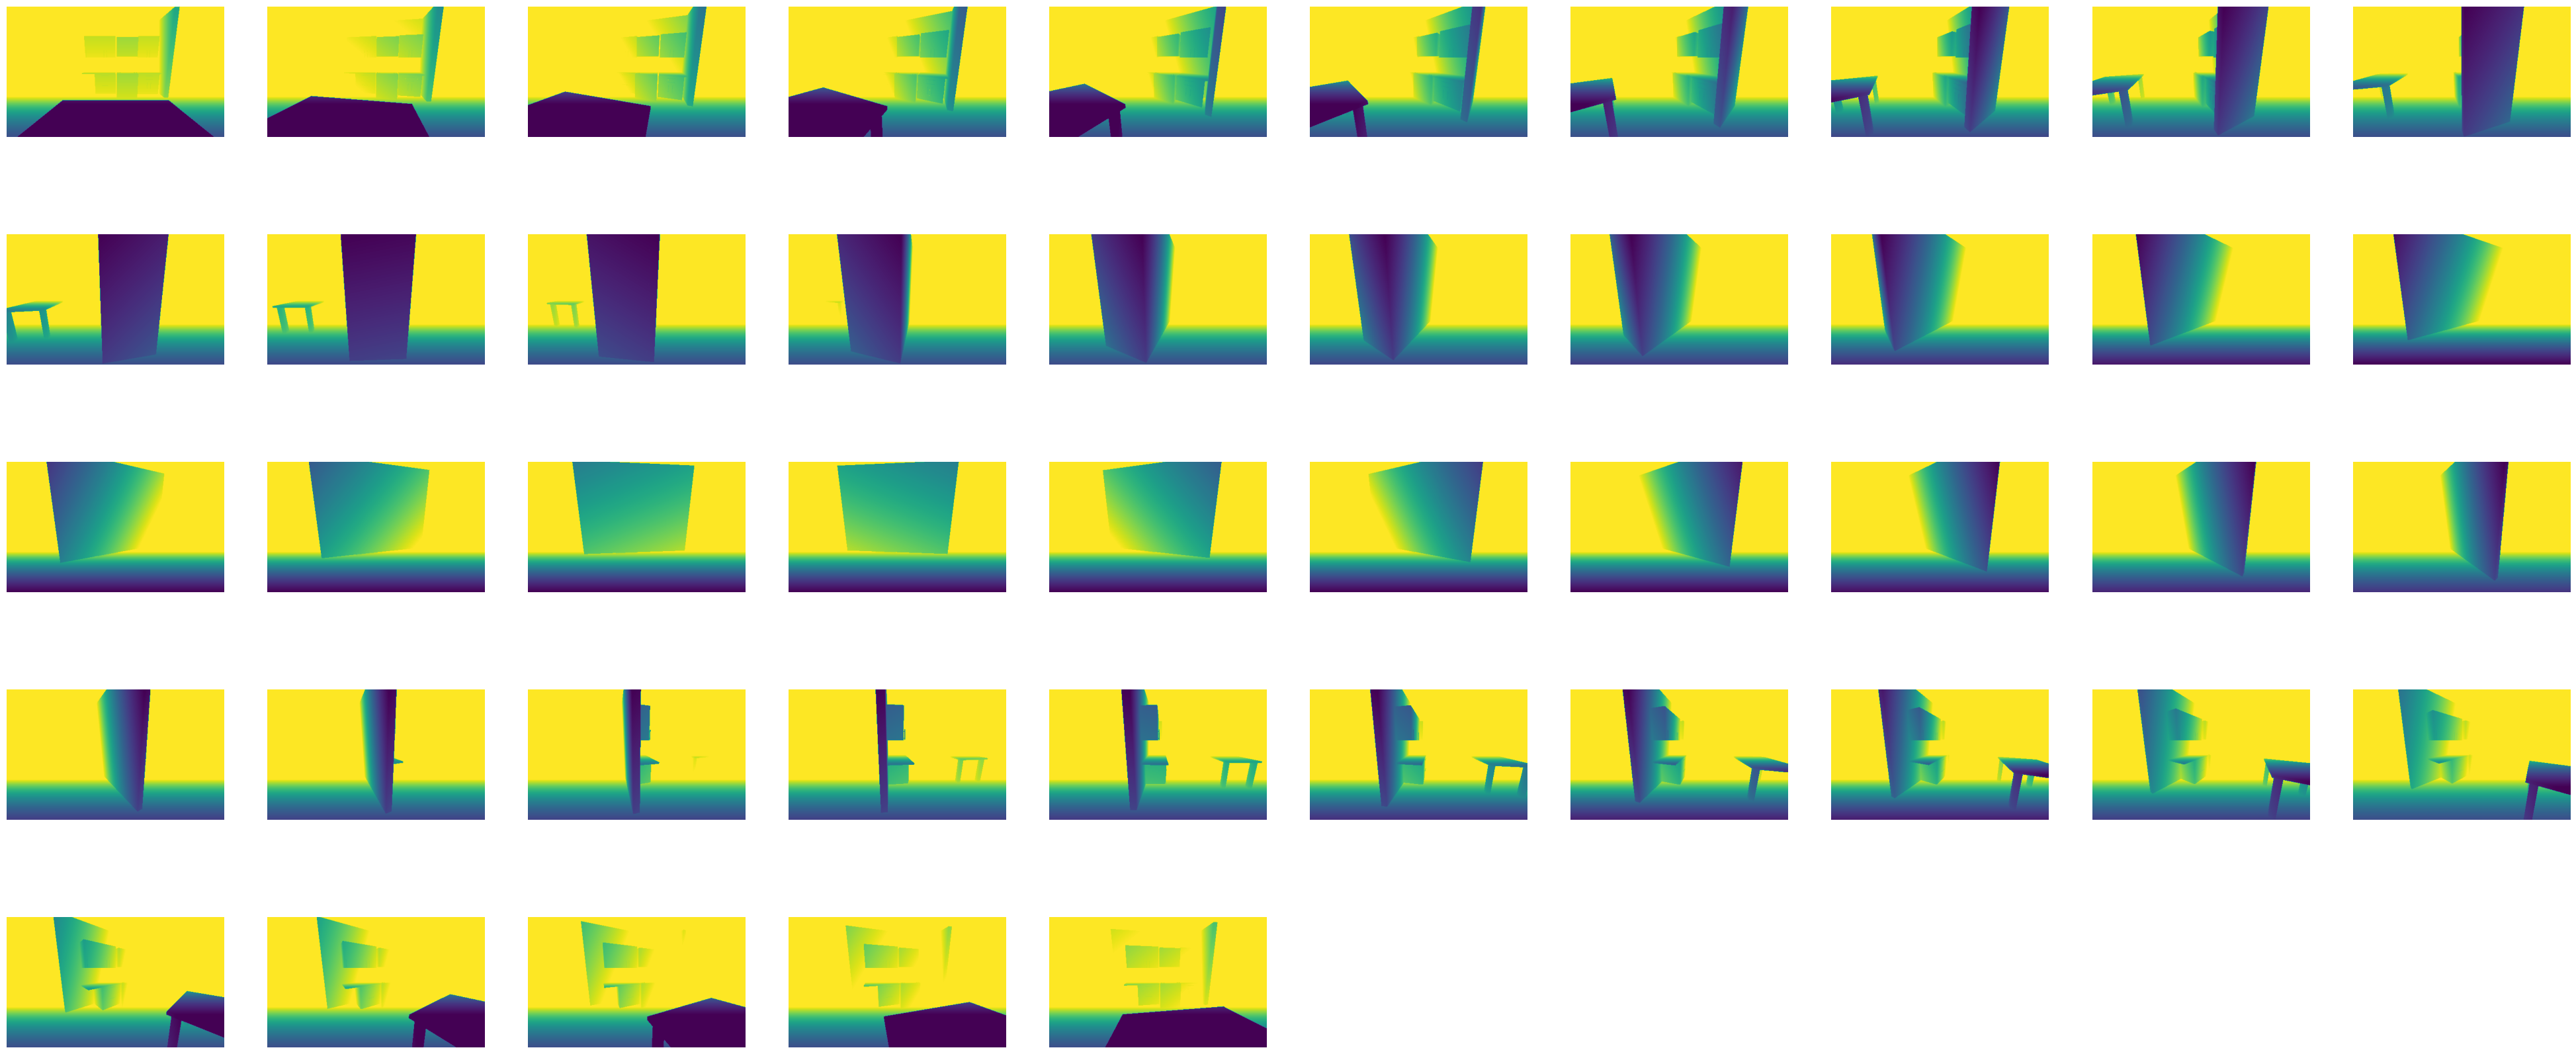

In [43]:
from matplotlib import pyplot as plt
import torch
images = plt.figure(figsize = (50, 35))
depths = plt.figure(figsize = (50, 35))
for i, items in enumerate(dataset):
    if i % 2 != 0:
        continue
    ax1 = images.add_subplot(8, 10, i // 2 + 1)
    ax1.imshow(items[0].permute(1, 2, 0))
    ax1.axis('off')
    ax2 = depths.add_subplot(8, 10, i // 2 + 1)
    #print(items[1])
    depth = items[1].clamp(1, 3)
    #ax2.imshow(items[1].permute(1, 2, 0), vmax = items[1].max(), vmin = items[1].min())
    #xi, yi = torch.meshgrid(torch.linspace(0, 1, depth.shape[1]), torch.linspace(0, 1, depth.shape[2]) )
    #ax2.contourf(xi, yi, depth[0], levels = 10000)
    ax2.imshow(depth[0])
    ax2.axis('off')
images, depths